<a href="https://colab.research.google.com/github/KoshKath/DataScience2/blob/main/HW2/DSHW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Датасет успешно скачан и распакован.

Содержимое папки 'UCI HAR Dataset':
   .DS_Store
   README.txt
   activity_labels.txt
   features.txt
   features_info.txt
   test
   train
Загрузка данных:
X_train shape: (7352, 128, 9)  (samples, timesteps, channels)
X_test  shape: (2947, 128, 9)
y_train shape: (7352,)
y_test  shape: (2947,)

Каналы сигналов: 9
Длина последовательности: 128
Epoch 1/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 1.0636 - val_loss: 0.8021
Epoch 2/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.7660 - val_loss: 0.7397
Epoch 3/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.7460 - val_loss: 0.7093
Epoch 4/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.7406 - val_loss: 0.6815
Epoch 5/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.7414 - val_loss: 0.6676
Epoch 6/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.7482 - val_loss: 0.6614
Epoch 7/70
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.7360 - val_loss: 0.6554
Epoch 8/70
46/46 ━━━

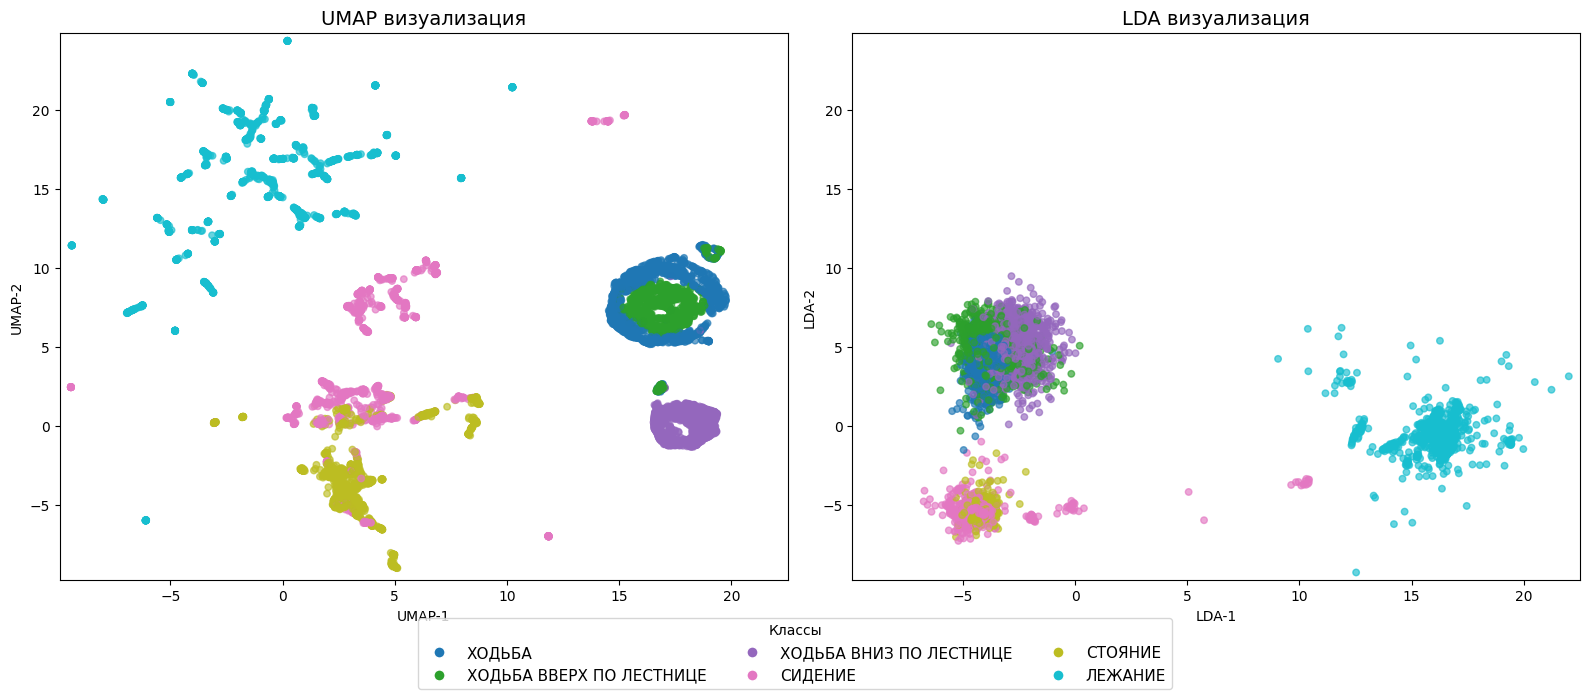

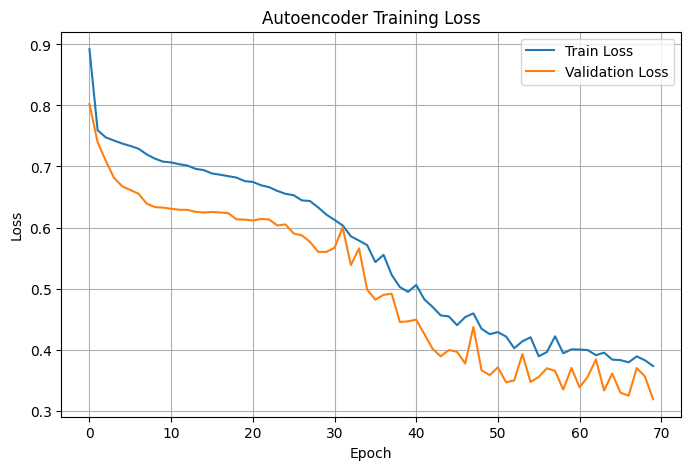

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


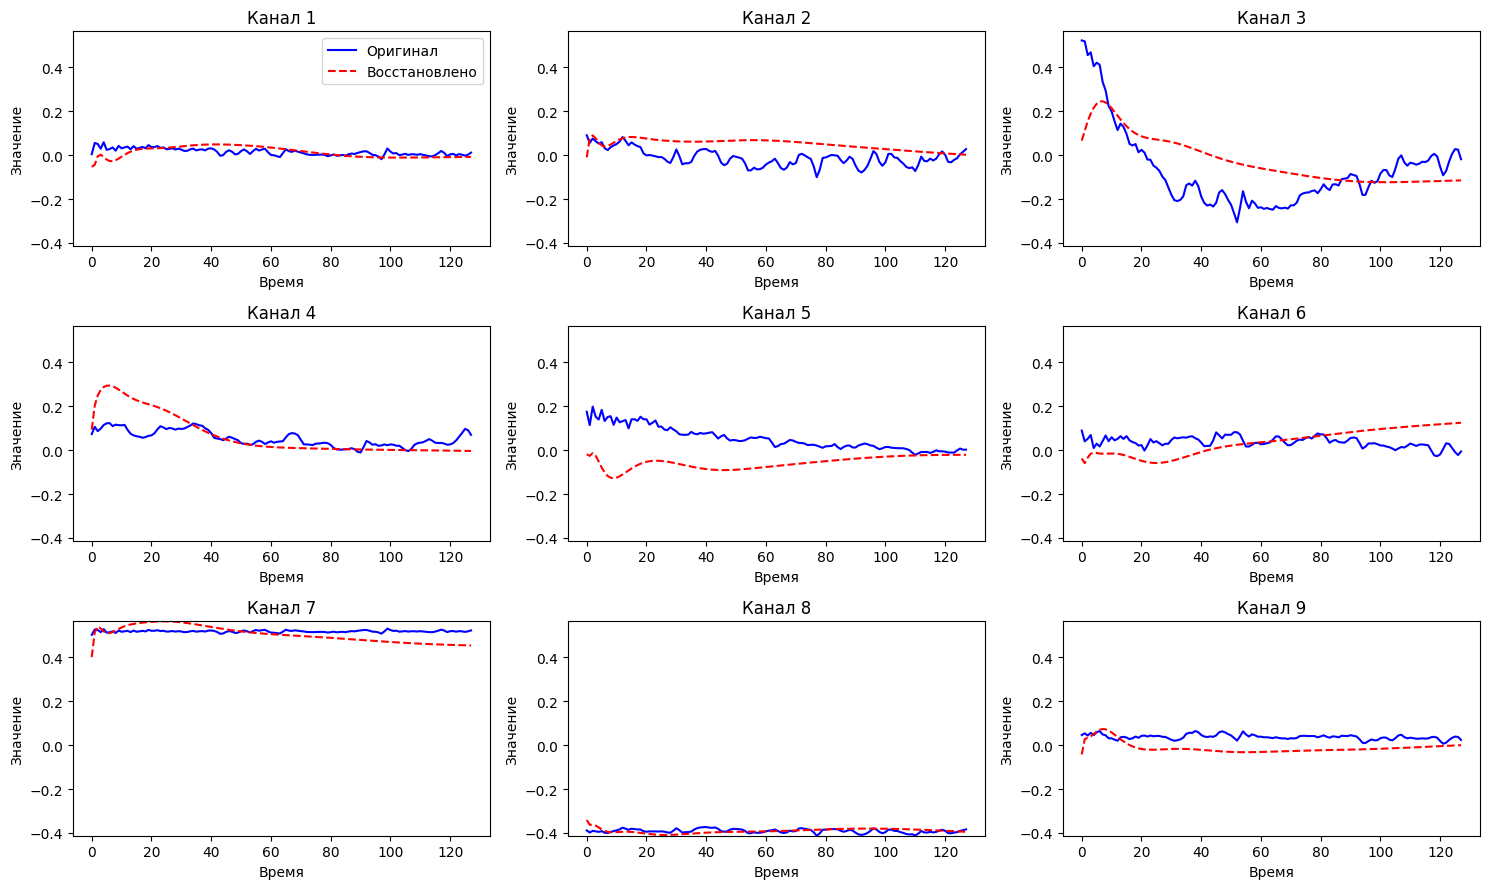

230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Форма эмбеддингов train: (7352, 32)
Форма эмбеддингов test : (2947, 32)

Точность на тестовой выборке: 0.9063

Отчёт классификации:
                           precision    recall  f1-score   support

                  ХОДЬБА       0.93      0.91      0.92       496
ХОДЬБА ВВЕРХ ПО ЛЕСТНИЦЕ       0.97      0.89      0.92       471
 ХОДЬБА ВНИЗ ПО ЛЕСТНИЦЕ       0.85      0.99      0.92       420
                 СИДЕНИЕ       0.84      0.80      0.82       491
                 СТОЯНИЕ       0.85      0.86      0.86       532
                 ЛЕЖАНИЕ       1.00      1.00      1.00       537

                accuracy                           0.91      2947
               macro avg       0.91      0.91      0.91      2947
            weighted avg       0.91      0.91      0.91      2947



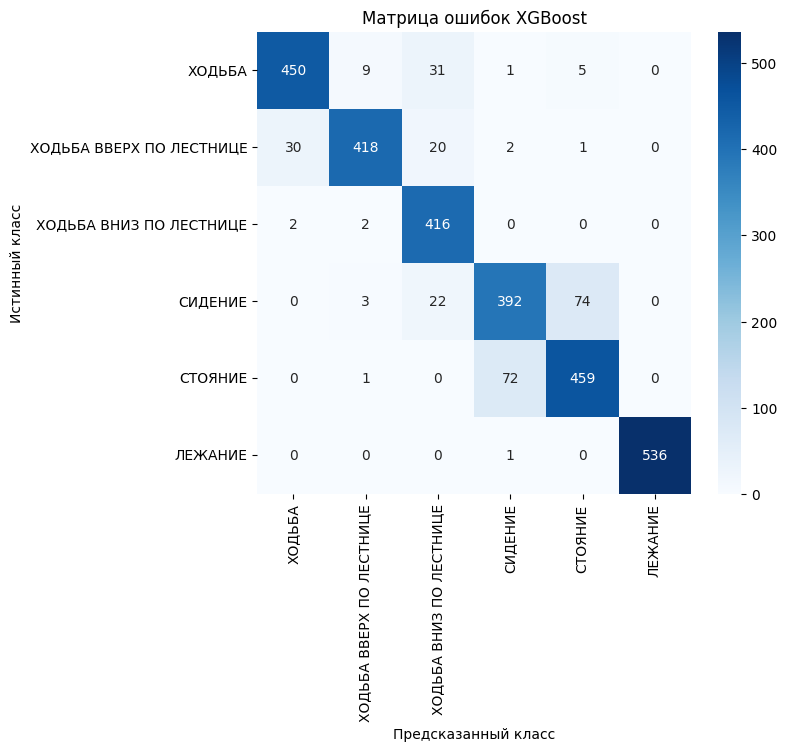

In [ ]:
# main.py
import pandas as pd
import numpy as np
import download_data as dw
import load_data as ld
import preprocess_data as pd
import gru_autoencoder as gruen
import plot_latent_umap_lda as pltl
import plot_autoencoder_results as pltr
import plot_feature_reconstruction as pltf
import extract_features as exf
import classify_xgboost as clsxgb

# скачивание данных
dw.download_data()
# загрузка данных
X_train, y_train, X_test, y_test = ld.load_data()
# препроцессинг данных
X_train, y_train, X_test, y_test = pd.preprocess_data(X_train, y_train, X_test, y_test)
# создание автоэнкодера GRU
autoencoder, encoder, history = gruen.gru_autoencoder(X_train)
# получение скрытого пространства
X_latent = encoder.predict(X_train)
# визуализация скрытого пространства с использ-м UMAP и LDE
pltl.plot_latent_umap_lda(X_latent, y_train)
# визуализация результатов обучения атоэнкода
pltr.plot_autoencoder_results(history)
# визуализация реконструкции атоэнкодером первого наблюдения
pltf.plot_feature_reconstruction(autoencoder, X_train, sample_idx=0)
# фичи, полученные автоэнкодером
Z_train, Z_test = exf.extract_features(encoder, X_train, X_test)
# применение XGBClassifier
xgb_model = clsxgb.classify_xgboost(Z_train, Z_test, y_train, y_test)

In [ ]:
# download_data.py
import os
import urllib.request
import zipfile

def download_data(data_dir='UCI HAR Dataset'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'

    if not os.path.exists(data_dir):
        zip_path = '/tmp/UCI_HAR_Dataset.zip'
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall()
        print("Датасет успешно скачан и распакован.")
    else:
        print("Датасет уже существует.")
    print("\nСодержимое папки '{}':".format(data_dir))
    for item in sorted(os.listdir(data_dir)):
        print("  ", item)

In [ ]:
# load_data.py
import numpy as np
import os
import pandas as pd

def load_data(data_dir='UCI HAR Dataset'):

    def load_split(split):
        signals = [
            'body_acc_x', 'body_acc_y', 'body_acc_z',
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
            'total_acc_x', 'total_acc_y', 'total_acc_z'
        ]

        X = []

        for s in signals:
            path = os.path.join(data_dir, split, 'Inertial Signals', f'{s}_{split}.txt')
            arr = np.loadtxt(path)
            X.append(arr)

        # (9, samples, 128) → (samples, 128, 9)
        X = np.transpose(np.array(X), (1, 2, 0))

        # метки классов
        y_path = os.path.join(data_dir, split, f'y_{split}.txt')
        y = np.loadtxt(y_path).astype(int).ravel() - 1

        return X, y

    X_train, y_train = load_split('train')
    X_test,  y_test  = load_split('test')

    print("Загрузка данных:")
    print(f"X_train shape: {X_train.shape}  (samples, timesteps, channels)")
    print(f"X_test  shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test  shape: {y_test.shape}")
    print("\nКаналы сигналов: 9")
    print("Длина последовательности: 128")

    return X_train, y_train, X_test, y_test

In [ ]:
# preprocess_data.py
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_train, y_train, X_test, y_test):
    n_samples, timesteps, n_channels = X_train.shape

    # разворот только последнего axis
    X_train_2d = X_train.reshape(-1, n_channels)
    X_test_2d  = X_test.reshape(-1, n_channels)

    scaler = StandardScaler()
    X_train_2d = scaler.fit_transform(X_train_2d)
    X_test_2d  = scaler.transform(X_test_2d)

    # обратно в (samples, timesteps, channels)
    X_train = X_train_2d.reshape(n_samples, timesteps, n_channels)
    X_test  = X_test_2d.reshape(X_test.shape[0], timesteps, n_channels)

    return X_train, y_train, X_test, y_test

In [ ]:
# gru_autoencoder.py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed, BatchNormalization, Dropout

def gru_autoencoder(X_train):
    timesteps = X_train.shape[1]
    features  = X_train.shape[2]
    latent_dim = 32

    inputs = Input(shape=(timesteps, features))

    # Encoder
    x = GRU(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = GRU(64)(x)
    x = BatchNormalization()(x)

    encoded = Dense(latent_dim, activation="linear", name="latent")(x)

    # Decoder
    x = RepeatVector(timesteps)(encoded)

    x = GRU(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = GRU(128, return_sequences=True)(x)
    x = BatchNormalization()(x)

    outputs = TimeDistributed(Dense(features, activation="linear"))(x)

    autoencoder = Model(inputs, outputs)
    encoder = Model(inputs, encoded)

    autoencoder.compile(optimizer='adam', loss='mse')

    history = autoencoder.fit(
        X_train, X_train,
        validation_split=0.2,
        epochs=70,
        batch_size=128,
        verbose=1
    )

    return autoencoder, encoder, history

In [ ]:
# plot_latent_umap_lda.py
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def plot_latent_umap_lda(X_latent, y, deterministic=False):
    class_names = ["ХОДЬБА", "ХОДЬБА ВВЕРХ ПО ЛЕСТНИЦЕ", "ХОДЬБА ВНИЗ ПО ЛЕСТНИЦЕ",
                   "СИДЕНИЕ", "СТОЯНИЕ", "ЛЕЖАНИЕ"]

    # UMAP
    if deterministic:
        umap_reducer = umap.UMAP(
            n_components=2,
            random_state=42,
            n_jobs=1
        )
    else:
        umap_reducer = umap.UMAP(
            n_components=2,
            random_state=None,
            n_jobs=-1
        )

    X_umap = umap_reducer.fit_transform(X_latent)

    # LDA
    lda = LDA(n_components=2)
    X_lda = lda.fit_transform(X_latent, y)

    # цвета
    unique_classes = np.unique(y)
    cmap = plt.get_cmap("tab10", len(unique_classes))

    # общий масштаб
    all_data = np.vstack([X_umap, X_lda])
    x_min, x_max = all_data[:, 0].min() - 0.5, all_data[:, 0].max() + 0.5
    y_min, y_max = all_data[:, 1].min() - 0.5, all_data[:, 1].max() + 0.5

    # сами графики
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), facecolor='white')

    # UMAP
    axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap=cmap, alpha=0.65, s=22)
    axes[0].set_title("UMAP визуализация", fontsize=14)
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[0].set_xlabel("UMAP-1")
    axes[0].set_ylabel("UMAP-2")

    # LDA
    axes[1].scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap=cmap, alpha=0.65, s=22)
    axes[1].set_title("LDA визуализация", fontsize=14)
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_xlabel("LDA-1")
    axes[1].set_ylabel("LDA-2")

    # определение легенды внизу
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=name,
                   markerfacecolor=cmap(i), markersize=8)
        for i, name in enumerate(class_names)
    ]

    fig.legend(handles=handles, loc='lower center', ncol=3, title="Классы", fontsize=11)

    # отступ
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()

In [ ]:
# plot_autoencoder_results.py
import matplotlib.pyplot as plt

def plot_autoencoder_results(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Autoencoder Training Loss')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
# plot_feature_reconstruction.py
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_reconstruction(autoencoder, X, sample_idx=0):
    # выбор одного примера
    X_sample = X[sample_idx:sample_idx+1]
    X_reconstructed = autoencoder.predict(X_sample)

    n_channels = X.shape[2]
    timesteps = X.shape[1]

    # определение общего масштаба по Y для всех графиков
    y_min = min(X_sample.min(), X_reconstructed.min())
    y_max = max(X_sample.max(), X_reconstructed.max())

    n_cols = 3
    n_rows = int(np.ceil(n_channels / n_cols))

    plt.figure(figsize=(5 * n_cols, 3 * n_rows))

    for i in range(n_channels):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.plot(np.arange(timesteps), X_sample[0, :, i], label='Оригинал', color='blue')
        plt.plot(np.arange(timesteps), X_reconstructed[0, :, i], label='Восстановлено', color='red', linestyle='--')
        plt.title(f'Канал {i+1}')
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.ylim(y_min, y_max)
        if i == 0:
            plt.legend(loc='upper right')
        plt.tight_layout()

    plt.show()

In [ ]:
# extract_features.py
def extract_features(encoder, X_train, X_test):
    Z_train = encoder.predict(X_train)
    Z_test  = encoder.predict(X_test)
    print("Форма эмбеддингов train:", Z_train.shape)
    print("Форма эмбеддингов test :", Z_test.shape)
    return Z_train, Z_test

In [ ]:
# classify_xgboost.py
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def classify_xgboost(Z_train, Z_test, y_train, y_test):
    activity_names = ['ХОДЬБА', 'ХОДЬБА ВВЕРХ ПО ЛЕСТНИЦЕ',
                      'ХОДЬБА ВНИЗ ПО ЛЕСТНИЦЕ', 'СИДЕНИЕ',
                      'СТОЯНИЕ', 'ЛЕЖАНИЕ']

    # создание классификатора XGBoost
    xgb = XGBClassifier(
        max_depth=6,
        n_estimators=400,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss'
    )

    # обучение модели
    xgb.fit(Z_train, y_train)

    # предсказание на тестовой выборке
    y_pred = xgb.predict(Z_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nТочность на тестовой выборке: {acc:.4f}\n")
    print("Отчёт классификации:\n", classification_report(y_test, y_pred, target_names=activity_names))

    # матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activity_names, yticklabels=activity_names)
    plt.title("Матрица ошибок XGBoost")
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")
    plt.show()

    return xgb